In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Building a Traffic Sign Recognition Classifier, Deep Learning Approach 

## 1. Overview  

In this project, I train a CNN model to classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). Below I discuss about the general steps of the pipeline:  

- Loading the provided raw data, **training**, **validation**, and **test** data sets. 
- exploring the raw data, by checking the size for each category, visualizing, and pre-processing the raw-data to improve model performance in general.  
- Modifying/Processing the raw images and storing the processed ones in associated pickle files, so that they can be reloaded for next trial runs, as needed.  
- Defining the CNN model and finetuning the hyper-parameters to get the best performance, a trade-off between accuracy and speed is also important.  
- Test and visualize the performance on the **test** data set.  
- Visualize itermediate layers' outputs.  

> **Note**: `Cnn` wrapper class is created alongside this jupyter notebook for better code review and readability. The concept is similar to that os `Keras` library, but of course supporting a lot more limited functionalities, just to cover the requirements of this project.  

## 2. Basic summary of the data set  

### 2-1. Sample size of each category  

This traffic sign dbase consists of 43 caegories as listed below. The original data set size shows the size of each dataset for each category. As explained below, more fake data is generated and added to the original dataset for training purpose. The size of the augmented and pre=processd data is eually set to be 1440 across all categories, as shown below (a fair training data set). 

|Class ID  |  Description          |  Original Training Dataset Size  |  Validation Dataset Size  |  Test Dataset Size  |  Augmented Training Dataset Size  |  
|:--:|:---------------------------:|:--------------------------------:|:-------------------------:|:-------------------:|:-------------:
0  |    Speed limit (20km/h)                                 |  180                             |  30                       |  60                 |  1440
1  |    Speed limit (30km/h)                                 |  1980                            |  240                      |  720                |  1440
2  |    Speed limit (50km/h)                                 |  2010                            |  240                      |  750                |  1440
3  |    Speed limit (60km/h)                                 |  1260                            |  150                      |  450                |  1440
4  |    Speed limit (70km/h)                                 |  1770                            |  210                      |  660                |  1440
5  |    Speed limit (80km/h)                                 |  1650                            |  210                      |  630                |  1440
6  |    End of speed limit (80km/h)                          |  360                             |  60                       |  150                |  1440
7  |    Speed limit (100km/h)                                |  1290                            |  150                      |  450                |  1440
8  |    Speed limit (120km/h)                                |  1260                            |  150                      |  450                |  1440
9  |    No passing                                           |  1320                            |  150                      |  480                |  1440
10 |    No passing for vehicles over 3.5 metric tons         |  1800                            |  210                      |  660                |  1440
11 |    Right-of-way at the next intersection                |  1170                            |  150                      |  420                |  1440
12 |    Priority road                                        |  1890                            |  210                      |  690                |  1440
13 |    Yield                                                |  1920                            |  240                      |  720                |  1440
14 |    Stop                                                 |  690                             |  90                       |  270                |  1440
15 |    No vehicles                                          |  540                             |  90                       |  210                |  1440
16 |    Vehicles over 3.5 metric tons prohibited             |  360                             |  60                       |  150                |  1440
17 |    No entry                                             |  990                             |  120                      |  360                |  1440
18 |    General caution                                      |  1080                            |  120                      |  390                |  1440
19 |    Dangerous curve to the left                          |  180                             |  30                       |  60                 |  1440
20 |    Dangerous curve to the right                         |  300                             |  60                       |  90                 |  1440
21 |    Double curve                                         |  270                             |  60                       |  90                 |  1440
22 |    Bumpy road                                           |  330                             |  60                       |  120                |  1440
23 |    Slippery road                                        |  450                             |  60                       |  150                |  1440
24 |    Road narrows on the right                            |  240                             |  30                       |  90                 |  1440
25 |    Road work                                            |  1350                            |  150                      |  480                |  1440
26 |    Traffic signals                                      |  540                             |  60                       |  180                |  1440
27 |    Pedestrians                                          |  210                             |  30                       |  60                 |  1440
28 |    Children crossing                                    |  480                             |  60                       |  150                |  1440
29 |    Bicycles crossing                                    |  240                             |  30                       |  90                 |  1440
30 |    Beware of ice/snow                                   |  390                             |  60                       |  150                |  1440
31 |    Wild animals crossing                                |  690                             |  90                       |  270                |  1440
32 |    End of all speed and passing limits                  |  210                             |  30                       |  60                 |  1440
33 |    Turn right ahead                                     |  599                             |  90                       |  210                |  1440
34 |    Turn left ahead                                      |  360                             |  60                       |  120                |  1440
35 |    Ahead only                                           |  1080                            |  120                      |  390                |  1440
36 |    Go straight or right                                 |  330                             |  60                       |  120                |  1440
37 |    Go straight or left                                  |  180                             |  30                       |  60                 |  1440
38 |    Keep right                                           |  1860                            |  210                      |  690                |  1440
39 |    Keep left                                            |  270                             |  30                       |  90                 |  1440
40 |    Roundabout mandatory                                 |  300                             |  60                       |  90                 |  1440
41 |    End of no passing                                    |  210                             |  30                       |  60                 |  1440
42 |    End of no passing by vehicles over 3.5 metric tons   |  210                             |  30                       |  90                 |  1440

![Sample Sizes Distribution](Images/sample-distribution-01.png)

### 2-2. Sample images before and after processing (whitenning)  

While exploring the raw data, I noticed several images that were dark, not really highlighting the features very well. To improve on it, I developed function `Cnn.whiten_images_self_mean` that takes an image as an input and slightly enlighten - or whiten - it with respect to its own average RGB component values. That can of course be performed on HLS space, increasing the light component; However, this approach worked well for now. In addition, there are also some general useful guidelines that I followed for data pre-processing, such as the guidelines suggested in the following link: [Image Pre-processing for Deep Learning](https://towardsdatascience.com/image-pre-processing-c1aec0be3edf).   

Below you can see some examples of the images before and after whitening for each category.


Raw Training Images          | --- |  Processed (whitenned) Training Images  
:------------------:| :---: |:------------------:
![Sample Image](Images/selected-images-01.png) | ---  |  ![Sample Image](Images/selected-images-whitenned-01.png)  

It should be noted that while processing the raw images, I define a rectangle of interest by introducing left, right, top, and bottom offsets, outside which I fill the image with zero padding. This helped get better whitenned images by removing some boundary background noises that are not part of the features to be captures. This also helps remove some of the secondary signs that may be present beside the main traffic sign. 

***
> **Note**:
There are couple of other appraoches proposed in some literatures for image whitenning that I tried them, but they did not work as expected for me. One of them, that I already tried, is called **Zero Components Analysis** or **ZCA** for short. I think this a great method but it requires more careful considerations for the training dataset. For example, after exploring some of the images whitenned using ZCA, the results were so deviated from the original image that I could not identify what the original image was. But it is still worth exploring and I would work on it in a future work attempt.  
- [LINK-1: Preprocessing for deep learning: from covariance matrix to image whitening](https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/)
- [LINK-2: Preprocessing for deep learning: from covariance matrix to image whitening](https://www.freecodecamp.org/news/preprocessing-for-deep-learning-from-covariance-matrix-to-image-whitening-9e2b9c75165c/)  

### 2-3. Data Augmentation - generating fake training data  

**Why is 'data augmentation' required?**  

After examining the provided raw data, I observed that it may not provide enough data for some categories,; in other word, the training dataset does not provide fair number of samples for each category. For example, some features have significantly more data than ohers. Here is the distribution of number of images of each category (from column **'Original Dataset Size'** of  above table):  
    
`features_counts: [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920 690  540  360  990 1080  180  300  270  330 450  240 1350  540  210 480  240  390  690  210  599  360 1080  330  180 1860  270  300  210 210]`
    
So it is needed to augment the data in a logical way. My simple approach is to generate some fake images of each category by applying slight noises. Function `Cnn.augment_data` is created to perform this job. After data augmentation, equal sample size of each category is selected form the post-processed and augmented data and the results are saved into the `traffic-signs-data` directory for future uses. 
    
> **Note**: This task needs to be run only once, therefore for future runs, the post-processed data will be loaded for training, validation, and test steps. 
    
After training-data augmentation process, each category will have enough number of data as follows. 
    
`features_counts: [1440, 3240, 3270, 2520, 3030, 2910, 1620, 2550, 2520, 2580, 3060, 2430, 3150, 3180, 1950, 1800, 1620, 2250, 2340, 1440, 1560, 1530, 1590, 1710, 1500, 2610, 1800, 1470, 1740, 1500, 1650, 1950, 1470, 1859, 1620, 2340, 1590, 1440, 3120, 1530, 1560, 1470, 1470]`  
        
However, the training data is loaded such that each category has equal sample size as follows (from column **'Augmented and Pre-Processed Dataset Size'** of  above table):  
    
`features_counts: [1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440]`  


## 3. Design and Test a Model Architecture  

After trying to put a few layers, I decided to use six CNN layers followed by two fully-connected - FC - layers. In general, the overal architecture is very similar to that of LeNet as shown below: 

![LeNet](Images/lenet.png)

For this project, the architecture contains the following features (3 channels for the zeroth layer, considering RGB channels of the image inputs):  

  - **Conv. Layer-1**: 
    - layet depth=16
    - kernel size=(8, 8)
    - output layer size: (?, 24, 24, 16)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **Conv. Layer-2**: 
    - layet depth=32
    - kernel size=(5, 5)
    - output layer size: (?, 19, 19, 32)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **Conv. Layer-3**: 
    - layet depth=32
    - kernel size=(5, 5)
    - output layer size: (?, 14, 14, 32)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **Conv. Layer-4**: 
    - layet depth=64
    - kernel size=(5, 5)
    - output layer size: (?, 9, 9, 32)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **Conv. Layer-5**: 
    - layet depth=64
    - kernel size=(5, 5)
    - output layer size: (?, 4, 4, 64)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **Conv. Layer-6**: 
    - layet depth=128
    - kernel size=(2, 2)
    - output layer size: (?, 2, 2, 128)
    - Batch normalization 
    - ReLU
    - Max pool 

  - **FC Layer-1**: 
    - number of parameters=128

  - **FC Layer-2**: 
    - number of parameters=64

### 3-1. Results and Discussions   

For testing the model, using original data provided, I used a light model to study learning rate, the training loss and validation accuracy. I used a simple trick to reduce the number of parameters. The trick was to use a single fully-conneected layer to try different parramters. That helped me determine which parameters to be used for the final model architecture. 

- **learning rate**: I initialy set `learning_rate = 1.0e-3` which is a good value to start with. Then I noticed that training loss fluctuates when the validation accuracy was still not satisfactory. Then I decided to lower it down, `learning_rate = 1.0e-4`. Adam optimizer would take care of gradually increasing and adapting the learning rate based on the performance of the system. 

- **Optimizer**: I used both SGD and Adam optimizers for comparison. In terms of final results the differences are marginal; however, since Adam optimizer uses some internal measures to adapt the learning rate to the performance of the system, it would take less number of efforts to decrease test loss. Therefore, I finally used Adam after comparing the two results.  

- **batch size**: I studied both `batch_size = 128` and `batch_size = 512` for the light system. Ideally the bigger batch size should perform beter as the gradients would be calculated and back-propagated using the error of the bigger training set data. However, I did not see substantial difference between the final results - very marginal. So I finally chose `batch_size = 512`.  

- **number of iteration over all batches**: For the trial / light model I tried these variabilities: `epochs = 30`, `epochs = 50`, and `epochs = 100`. The system would get to the satisfactory result after 30 iterations more or less and then the validation accuracy starts to fluctuate  while the training loss would keep decreasing. That means overfitting, as the error is calculated and back-propagated by the training loss, instead of vallidation error. However, for the final CNN model architecture, I used `epochs = 50`, ensuring that the validation accuracy meets and also sperceeds the final project requiremnts.  

- **dropout**: I first started with `keep_prob = 0.9` and then observed that the model did not generalize well and model learned the training data, i.e. the model overfit the training data. By choosing `keep_prob = 0.8`, I observed that I can still force the validation accuracy would improve at lower training loss, i.e. improving overall model performaance.  

**Before Data Augmentation**  

After going through 100 iterations on the training data batches - `epochs = 100` - the validatoin accuracy of close to `89%` is achieved - using smaller network. Tracking the training-loss suggets that the model overfit the training data, as the test loss - using the training data - keep decreasing while validation accuracy almost saturates - see the training log below.  
    
`Training... start`  
`Epoch 10: Test Cost: 0.1957 --- Valid Accuracy: 0.8329`  
`Epoch 20: Test Cost: 0.0632 --- Valid Accuracy: 0.8719`  
`Epoch 30: Test Cost: 0.0262 --- Valid Accuracy: 0.8878`  
`Epoch 40: Test Cost: 0.0135 --- Valid Accuracy: 0.8961`  
`Epoch 50: Test Cost: 0.0165 --- Valid Accuracy: 0.8855`  
`Epoch 60: Test Cost: 0.0038 --- Valid Accuracy: 0.8882`  
`Epoch 70: Test Cost: 0.0050 --- Valid Accuracy: 0.8966`  
`Epoch 80: Test Cost: 0.0021 --- Valid Accuracy: 0.8868`  
`Epoch 90: Test Cost: 0.0024 --- Valid Accuracy: 0.8791`  
`Epoch 100: Test Cost: 0.0013 --- Valid Accuracy: 0.8871`  
`Training... end`  

**After Data Augmentation**:  
    After going through 50 iterations on the training data batches - `epochs = 50` - the validatoin accuracy of close to `97%` is achieved. Tracking the training-loss suggets that the model performance is resonable and it did not overfit the training data. This is later confirmed by using the **test** data set that is not exposed to the model at all. The overall test accuracy is observed to be `95%`. 

### 3-2. Test a Model on New Images  

As explained above, all the images I used for training, validation, and test purposes are already whitenned, based on the algorithm explained above. The overall summary of statistics of selected test images are listed below for all categories.  

Raw Test Images  | --- |  Processed (whitenned) Test Images  
:------------------:| :---: |:------------------:
![Sample Image](Images/selected-test-images-01.png) | ---  |  ![Sample Image](Images/selected-test-images-whitenned-01.png)  

### 3-3. Testing the performance  

In this section I provide the following briefly: 

- Measuring the model performance by plotting ROC - AUC curve  
- Visualizing the first top-five scored predictions of 10 samples, picked from test dataset. Tensorflow provides function `tf.nn.top_k` that can sort the scores of the output layer predictions - softmax in this project. 

Performance |  
:------------------:|  
![ROC-AUC](Images/roc-auc-01.png) | 
:------------------:|  
![Softmax Predictions](Images/softmax-01.png)  


### 3-4. Visualize the Neural Network's State with Test Images  

Visualization  |  
:------------------:|  
![Selected Input](Images/layers-output-input-01.png) | 
:------------------:|  
![Layer Output](Images/layers-output-01.png)  


### 3-5. Potential Areas of Improvement  

I can think of couple of improvement areas that I would like to explore. 

- **Data Refinement**:  
  By looking at the selected training data, one can refine the training data set by further pre-processing the raw data. The possible refinement areas are:  
  - Further focusing on the main feature by removing secondary objects present in the background.  
  - Removing background images.  
   
- **Utilizing more training data**:  
  In general, by adding more clear and clean data of each category, the performance should be improved. Currently, the data augmentation is done by applying some level of noise. However, by adding more cear publicly-available data - that are clean and clear - one may improve the performance.  
   
- **Utilizing Two Parallel Models**:  
  By examining the wrong predictions, it is observed that some of them are actually from the first 9 categories that are related to speed limit signs. Therefore, One way is to train a CNN model solely for the first 9 categories and the other one for all 43 categories - or just the other 34 categories. The final score will be decided after passing the test images into both CNNs. One benefit is that one may use smaller CNN size to get better speed and accuracy performance.  



In [2]:
# Load pickled data
import pickle

import pandas as pd
import cv2
import numpy as np
from sklearn import preprocessing
import os
from random import shuffle
import glob
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from keras.layers import Input, InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras
from keras import backend as K

Using TensorFlow backend.


In [3]:
training_raw_file = "traffic-signs-data/train.p"
validation_raw_file = "traffic-signs-data/valid.p"
testing_raw_file = "traffic-signs-data/test.p"

training_processed_file = "traffic-signs-data/train-processed.p"
validation_processed_file = "traffic-signs-data/valid-processed.p"
testing_processed_file = "traffic-signs-data/test-processed.p"

csv_features_file = "signnames.csv"

### Dataset Exploration and Pre-Processing of Raw Data  

**Dataset Summary** step includes: 

- loading the already-provided raw data  
- data augmentation  
- Pre-processing: image whitenning  
- storing the pre-processed data into new pickle files  

> **Note**: This cell needs to be run only once - although it can be run several times, but not really needed. In the following cells below, the generated data file will be loaded and used for training purposes. 

In [4]:
from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

# in case resizing is required - not used in this pipeline
target_image_size = 32
epsilon = 0.0

with open(training_raw_file, mode="rb") as f:
    train_raw_data = pickle.load(f)
with open(validation_raw_file, mode="rb") as f:
    valid_raw_data = pickle.load(f)
with open(testing_raw_file, mode="rb") as f:
    test_raw_data = pickle.load(f)

# pre-processing the raw data 

x_train_raw_data, y_train_raw_data = train_raw_data["features"], train_raw_data["labels"]
x_valid_raw_data, y_valid_raw_data = valid_raw_data["features"], valid_raw_data["labels"]
x_test_raw_data, y_test_raw_data = test_raw_data["features"], test_raw_data["labels"]

x_train_norm_data = Cnn.normalize(x_train_raw_data, approach="scale")
x_valid_norm_data = Cnn.normalize(x_valid_raw_data, approach="scale")
x_test_norm_data = Cnn.normalize(x_test_raw_data, approach="scale")

y_train_norm_data = y_train_raw_data


print("----------------------------- Dataset Exploration -----------------------------")
unique_label_ids = np.unique(y_train_norm_data)
features_counts = np.asanyarray([(np.where(y_train_norm_data == label_id))[0].size for label_id in unique_label_ids])
print("features count before data augmentation:\n", features_counts)


x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=0.05)
x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=-0.05)
x_train_norm_data, y_train_norm_data, features_counts = Cnn.augment_data(x_train_norm_data, y_train_norm_data, epsilon=0.05)

print("features count after data augmentation:\n", features_counts)

# Note: ZCA approach is not used for now 
# Cnn.whiten_images_zca(x_train_norm_data, train_processed_data["features"], batch_size=1000, epsilon=0.1)
# Cnn.whiten_images_zca(x_valid_norm_data, valid_processed_data["features"], batch_size=1000, epsilon=0.1)
# Cnn.whiten_images_zca(x_test_norm_data, test_processed_data["features"], batch_size=1000, epsilon=0.1)

# np.zeros_like(x_train_norm_data).astype(np.uint8)
train_processed_data = {"features":None, "labels":y_train_norm_data}
valid_processed_data = {"features":None, "labels":y_valid_raw_data}
test_processed_data = {"features":None, "labels":y_test_raw_data}

print("----------------------------- Whitenning Images -----------------------------")

train_processed_data["features"] = Cnn.whiten_images_self_mean(x_train_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                               epsilon=0.0, verbose=True)
valid_processed_data["features"] = Cnn.whiten_images_self_mean(x_valid_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                               epsilon=0.0, verbose=True)
test_processed_data["features"] = Cnn.whiten_images_self_mean(x_test_norm_data, batch_size=1000, width_offset=1, height_offset=1, 
                                                              epsilon=0.0, verbose=True)
# Note: useful for debugging only 
# train_processed_data = np.copy(train_raw_data)
# valid_processed_data = np.copy(valid_raw_data)
# test_processed_data = np.copy(test_raw_data)

with open(training_processed_file, mode="wb") as f:
    pickle.dump(train_processed_data, f)
with open(validation_processed_file, mode="wb") as f:
    pickle.dump(valid_processed_data, f)
with open(testing_processed_file, mode="wb") as f:
    pickle.dump(test_processed_data, f)

# releasing memory 

# train_raw_data = None
# valid_raw_data = None
# test_raw_data = None

# train_processed_data = None
# valid_processed_data = None
# test_processed_data = None


----------------------------- Dataset Exploration -----------------------------
features count before data augmentation:
 [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]
features count after data augmentation:
 [1440, 3240, 3270, 2520, 3030, 2910, 1620, 2550, 2520, 2580, 3060, 2430, 3150, 3180, 1950, 1800, 1620, 2250, 2340, 1440, 1560, 1530, 1590, 1710, 1500, 2610, 1800, 1470, 1740, 1500, 1650, 1950, 1470, 1859, 1620, 2340, 1590, 1440, 3120, 1530, 1560, 1470, 1470]
----------------------------- Whitenning Images -----------------------------
- pre-processing raw images and applying self-mean correction to whiten them... started
  completed!           
- pre-processing raw images and applying self-mean correction to whiten them... started
  completed!           
- pre-processing raw images and applying self-mean corre

### Exploring some of the post-processed images  


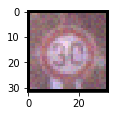

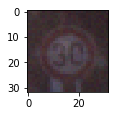

In [183]:
temp_images = train_processed_data["features"]
temp_labels = train_processed_data["labels"]

test_image_index = 2100

plt.figure(figsize=(1.5, 1.5))
plt.imshow(temp_images[test_image_index])

# =============================================================

temp_images = x_train_norm_data
temp_labels = y_train_norm_data

plt.figure(figsize=(1.5, 1.5))
plt.imshow(temp_images[test_image_index])


### Loading data sets from the post-processed pickle files 
- In this cell, already-preprocessed data files are loaded for training, validation, and test purposes.  


In [4]:
with open(training_processed_file, mode="rb") as f:
    train_data = pickle.load(f)
with open(validation_processed_file, mode="rb") as f:
    valid_data = pickle.load(f)
with open(testing_processed_file, mode="rb") as f:
    test_data = pickle.load(f)

"""
with open(training_raw_file, mode="rb") as f:
    train_data = pickle.load(f)
with open(validation_raw_file, mode="rb") as f:
    valid_data = pickle.load(f)
with open(testing_raw_file, mode="rb") as f:
    test_data = pickle.load(f)
"""


'\nwith open(training_raw_file, mode="rb") as f:\n    train_data = pickle.load(f)\nwith open(validation_raw_file, mode="rb") as f:\n    valid_data = pickle.load(f)\nwith open(testing_raw_file, mode="rb") as f:\n    test_data = pickle.load(f)\n'

### Preparing training, validation, and test data sets  

In [5]:
from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn


In [6]:
x_train_raw_data, y_train_raw_data = train_data["features"], train_data["labels"]
x_valid_raw_data, y_valid_raw_data = valid_data["features"], valid_data["labels"]
x_test_raw_data, y_test_raw_data = test_data["features"], test_data["labels"]

# in case resizing is required - not used in this pipeline
target_image_size = 32
    
features_df = pd.read_csv(csv_features_file)
unique_label_ids = [row["ClassId"] for _, row in features_df.iterrows()]
unique_label_names = [row["SignName"] for _, row in features_df.iterrows()]

n_train = x_train_raw_data.shape[0]
n_validation = x_valid_raw_data.shape[0]
n_test = x_test_raw_data.shape[0]

# shape of an traffic sign image
image_shape = x_train_raw_data.shape[1:4]

# unique classes/labels there are in the dataset
assert np.array_equal(np.sort(np.unique(y_train_raw_data)), np.sort(np.asarray(unique_label_ids))), \
    "There is a mismatch in the training data"

n_classes = len(unique_label_ids)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# n_classes = len(cnn.label_ids)

features_counts = [(np.where(train_data["labels"] == label_id))[0].size for label_id in unique_label_ids]
print("\nFeatures count of training set\n:", features_counts)
print("\nFeatures count of validation set\n:", [(np.where(valid_data["labels"] == label_id))[0].size for label_id in unique_label_ids])
print("\nFeatures count of test set\n:", [(np.where(test_data["labels"] == label_id))[0].size for label_id in unique_label_ids])

# =================================================================================================

x_train_raw_data, y_train_raw_data, new_features_counts = \
    Cnn.select_equally_sized_data_sets(x_train_raw_data, y_train_raw_data, n_classes=n_classes, 
                                       unique_label_ids=unique_label_ids, features_counts=features_counts)

print("\nFeatures counts after equal size selection:\n", new_features_counts)

Number of training examples = 88979
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Features count of training set
: [1440, 3240, 3270, 2520, 3030, 2910, 1620, 2550, 2520, 2580, 3060, 2430, 3150, 3180, 1950, 1800, 1620, 2250, 2340, 1440, 1560, 1530, 1590, 1710, 1500, 2610, 1800, 1470, 1740, 1500, 1650, 1950, 1470, 1859, 1620, 2340, 1590, 1440, 3120, 1530, 1560, 1470, 1470]

Features count of validation set
: [30, 240, 240, 150, 210, 210, 60, 150, 150, 150, 210, 150, 210, 240, 90, 90, 60, 120, 120, 30, 60, 60, 60, 60, 30, 150, 60, 30, 60, 30, 60, 90, 30, 90, 60, 120, 60, 30, 210, 30, 60, 30, 30]

Features count of test set
: [60, 720, 750, 450, 660, 630, 150, 450, 450, 480, 660, 420, 690, 720, 270, 210, 150, 360, 390, 60, 90, 90, 120, 150, 90, 480, 180, 60, 150, 90, 150, 270, 60, 210, 120, 390, 120, 60, 690, 90, 90, 60, 90]

Features counts after equal size selection:
 [1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440

In [7]:
# features_df.head(n=43)

### Pre-processing data loaded from (already-processed) pickle files  

Pre-processing steps include: 

- Normalization of loaded data between 0 and 1 
- One-hot encoding of the loaded labels 

In [8]:
import random

from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

cnn = Cnn()
cnn.init_model(unique_label_names, unique_label_ids)

x_train_data, y_train_data = Cnn.normalize(x_train_raw_data, approach="scale"), cnn.one_hot_encode(y_train_raw_data)
x_valid_data, y_valid_data = Cnn.normalize(x_valid_raw_data, approach="scale"), cnn.one_hot_encode(y_valid_raw_data)
x_test_data, y_test_data = Cnn.normalize(x_test_raw_data, approach="scale"), cnn.one_hot_encode(y_test_raw_data)


### Shuffle the traning data

In [9]:
labelled_data = list(zip(x_train_data, y_train_data))
random.shuffle(labelled_data)
random_x_train_data, random_y_train_data = zip(*labelled_data)

random_x_train_data = list(random_x_train_data)
random_y_train_data = list(random_y_train_data)


### Exploring and visualizing the shuffled training data  

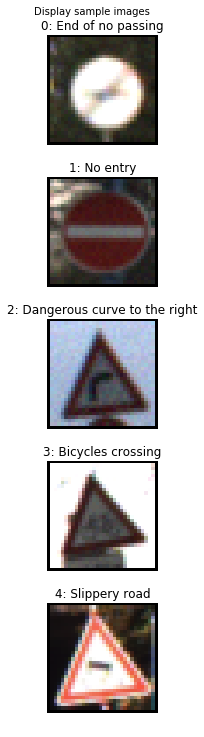

In [57]:
%matplotlib inline

cnn.display_images(random_x_train_data[0:5], random_y_train_data[0:5], normalized=True)

### Design and Test a Model Architecture 

Below, a CNN model architecture is created and examined. 

In [58]:
def create_conv_net(x, keep_prob, n_classes):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data - normalized image 
    : keep_prob: Placeholder tensor that hold dropout keep probability 
    : return: Tensor that represents logits
    """
    # Applying a few Convolution and Max Pool layers
    
    conv_ksize = (8, 8)  # filter dimensions
    # conv_ksize = (3, 3)  # filter dimensions
    conv_strides = (1, 1)
    pool_ksize = (2, 2)  # Filter kernel/patch dimensions [batch, height, width, channels]
    pool_strides = (1, 1)
    
    # batch_normalizer = tf.keras.layers.BatchNormalization(trainable=False)
    # x = batch_normalizer(x)
    
    # batch_normalizer = None
    
    #conv_layer = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_num_outputs = 16  # D_out : number of out filters
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-1", layer_name="hidden-layer-1", batch_normalizer=batch_normalizer)
    #conv_layer = normalize_batch(conv_layer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 32
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-2", layer_name="hidden-layer-2", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 32
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-3", layer_name="hidden-layer-3", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 64
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-4", layer_name="hidden-layer-4", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (5, 5)  # output layers dimensions
    conv_num_outputs = 64
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-5", layer_name="hidden-layer-5", batch_normalizer=batch_normalizer)
    
    # next layer
    conv_ksize = (2, 2)  # output layers dimensions
    conv_num_outputs = 128
    batch_normalizer = tf.keras.layers.BatchNormalization(trainable=True)
    conv_layer = cnn.conv2d_maxpool(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, 
                                    wieghts_name="weights-layer-6", layer_name="hidden-layer-6", batch_normalizer=batch_normalizer)
    
    ################################################
    # flattenning the layer
    x_tensor = cnn.flatten(conv_layer)

    # Applying a few fully connected layers
    
    # x_tensor = tf.layers.batch_normalization(x_tensor)
    x_tensor = cnn.fully_conn(x_tensor, 128)
    # normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    # x_tensor = normalize_batch(x_tensor)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)
    
    x_tensor = cnn.fully_conn(x_tensor, 64)
    # normalize_batch = tf.keras.layers.BatchNormalization(trainable=True)
    # x_tensor = normalize_batch(x_tensor)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)

    # Applying an Output Layer
    output_tensor = cnn.output(x_tensor, n_classes)
    
    return output_tensor


##############################
## Build the Neural Network ##
##############################

learning_rate = 1e-4

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = cnn.neural_net_image_input((target_image_size, target_image_size, 3))
y = cnn.neural_net_label_input(n_classes)
keep_prob = cnn.neural_net_keep_prob_input()

# Model
logits = create_conv_net(x, keep_prob, n_classes)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name="logits")

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

# tests.test_conv_net(conv_net)

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (8, 8)
conv_num_outputs: 16
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides (1, 1, 1, 1)
batch_normalizer: <tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001B05BD94EF0>
conv_layer: (?, 24, 24, 16)
conv2d_maxpool... End

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (5, 5)
conv_num_outputs: 32
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides (1, 1, 1, 1)
batch_normalizer: <tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001AF90EC3A20>
conv_layer: (?, 19, 19, 32)
conv2d_maxpool... End

conv2d_maxpool... Start
Checking inputs dimensions...
conv_ksize: (5, 5)
conv_num_outputs: 32
Checking strides dimensions...
conv_strides: (1, 1, 1, 1)
pool_ksize: (1, 2, 2, 1)
pool_strides (1, 1, 1, 1)
batch_normalizer: <tensorflow.python.keras.layers.normaliza

### Setting up hyper parameters and training on batches

In [10]:
epochs = 50
batch_size = 512
keep_probability = 0.80
save_model_path = "saved-model-01/"

### Results  

- **Before Data Augmentation**:  
    After going through 100 iterations on the training data batches - `epochs = 100` - the validatoin accuracy of close to `89%` is achieved (the results are overwritten by the new dataset, but the summary of performance is presented below). Tracking the training-loss suggets that the model overfit the training data, as the test loss - using the training data - keep decreasing while validation accuracy almost saturates - see the training log below.  
    
    
`Training... start`  
`Epoch 10: Test Cost: 0.1957 --- Valid Accuracy: 0.8329`  
`Epoch 20: Test Cost: 0.0632 --- Valid Accuracy: 0.8719`  
`Epoch 30: Test Cost: 0.0262 --- Valid Accuracy: 0.8878`  
`Epoch 40: Test Cost: 0.0135 --- Valid Accuracy: 0.8961`  
`Epoch 50: Test Cost: 0.0165 --- Valid Accuracy: 0.8855`  
`Epoch 60: Test Cost: 0.0038 --- Valid Accuracy: 0.8882`  
`Epoch 70: Test Cost: 0.0050 --- Valid Accuracy: 0.8966`  
`Epoch 80: Test Cost: 0.0021 --- Valid Accuracy: 0.8868`  
`Epoch 90: Test Cost: 0.0024 --- Valid Accuracy: 0.8791`  
`Epoch 100: Test Cost: 0.0013 --- Valid Accuracy: 0.8871`  
`Training... end`  

- **After Data Augmentation**:  
    After going through 50 iterations on the training data batches - `epochs = 50` - the validatoin accuracy of close to `97%` is achieved. Tracking the training-loss suggets that the model performance is resonable and it did not overfit the training data. This is later confirmed by using the **test** data set that is not exposed to the model at all. The overall test accuracy is observed to be `95%` (**see below**). 

### Training 

In [12]:
print("Training... start")

test_costs = []
valid_accuracies = []

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        
        batch_index = 0
        
        # for batch_features, batch_labels in CommonModules.load_preprocess_training_batch(batch_i, batch_size):
        for batch_features, batch_labels in cnn.batch_features_labels(random_x_train_data, random_y_train_data, batch_size):
            
            print("batch_index", batch_index, end="\r")
            batch_index += 1
            
            cnn.train_neural_network(sess, x, y, keep_prob, optimizer, keep_probability, batch_features, batch_labels)
            
        test_cost, valid_accuracy = cnn.print_stats(sess, x, y, keep_prob, batch_features, batch_labels, 
                                                    x_valid_data, y_valid_data, cost, accuracy, "Epoch {0:>2}: ".format(epoch + 1))
        
        test_costs.append(test_cost)
        valid_accuracies.append(valid_accuracy)
        
        if((epoch + 1) % 1 == 0):
            print("")
    
    # Save the Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

print("Training... end")

Training... start
Epoch  1: Test Cost: 2.3160   ---   Valid Accuracy: 0.3753
Epoch  2: Test Cost: 1.0150   ---   Valid Accuracy: 0.7288
Epoch  3: Test Cost: 0.5770   ---   Valid Accuracy: 0.8231
Epoch  4: Test Cost: 0.3781   ---   Valid Accuracy: 0.8535
Epoch  5: Test Cost: 0.2781   ---   Valid Accuracy: 0.8782
Epoch  6: Test Cost: 0.2048   ---   Valid Accuracy: 0.8909
Epoch  7: Test Cost: 0.1707   ---   Valid Accuracy: 0.8918
Epoch  8: Test Cost: 0.1275   ---   Valid Accuracy: 0.9168
Epoch  9: Test Cost: 0.1049   ---   Valid Accuracy: 0.9224
Epoch 10: Test Cost: 0.0936   ---   Valid Accuracy: 0.9295
Epoch 11: Test Cost: 0.0761   ---   Valid Accuracy: 0.9354
Epoch 12: Test Cost: 0.0639   ---   Valid Accuracy: 0.9433
Epoch 13: Test Cost: 0.0634   ---   Valid Accuracy: 0.9376
Epoch 14: Test Cost: 0.0548   ---   Valid Accuracy: 0.9458
Epoch 15: Test Cost: 0.0446   ---   Valid Accuracy: 0.9497
Epoch 16: Test Cost: 0.0411   ---   Valid Accuracy: 0.9460
Epoch 17: Test Cost: 0.0378   ---   Va

### Testing the performance 

- Measuring the model performance by plotting ROC - AUC curve  
- Visualizing the first top-five scored predictions of 10 samples, picked from test dataset  

In [11]:
fpr = {}
tpr = {}
auc = {}

In [12]:
import random

from importlib import reload
import classificationModules
reload(classificationModules)
from classificationModules import Cnn

cnn = Cnn()
cnn.init_model(unique_label_names, unique_label_ids)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from saved-model-01/
Testing Accuracy: 0.952



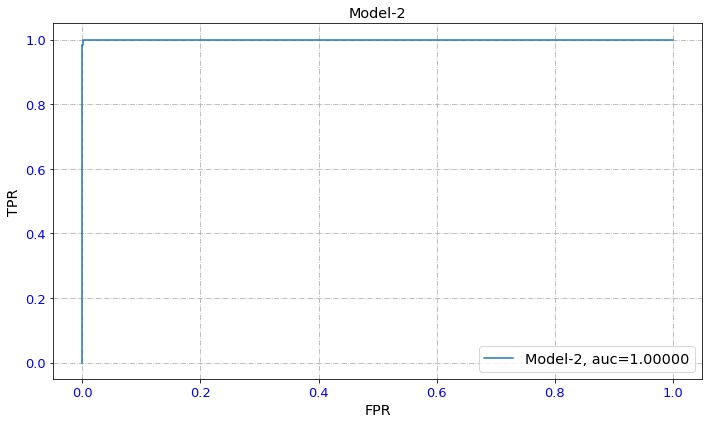

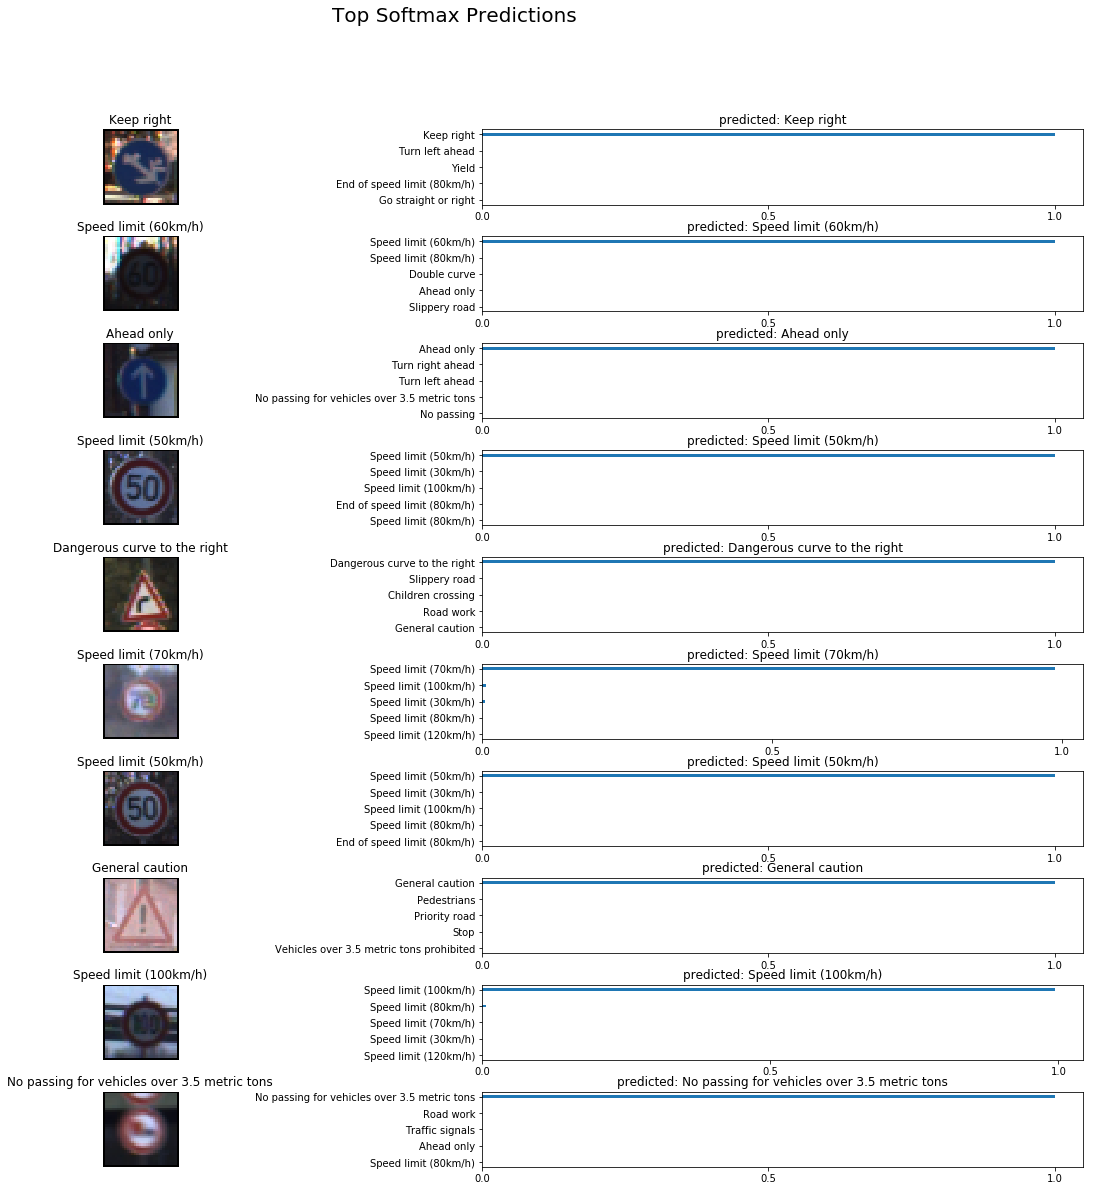

In [13]:
top_n_predictions = 5

def test_model(test_features, test_labels, n_classes, n_samples):
    """
    Test the saved model against the test dataset
    """

    # test_images, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    # loaded_graph = tf.get_default_graph()

    with tf.Session(graph=loaded_graph) as sess:
    # with tf.Session() as sess:
        # sess.run(tf.global_variables_initializer())
        
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + ".meta")
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name("x:0")
        loaded_y = loaded_graph.get_tensor_by_name("y:0")
        loaded_keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
        loaded_acc = loaded_graph.get_tensor_by_name("accuracy:0")
        
        # sess.run(tf.global_variables_initializer())
        
        # loaded_y = tf.expand_dims(loaded_y, 1)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in cnn.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            
            test_batch_count += 1
            
        print("Testing Accuracy: {0:0.3f}\n".format(test_batch_acc_total/test_batch_count))

        # ROC
        #all_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), label_categories_count), 
        #                                            feed_dict={loaded_x: test_features, loaded_y: test_labels, loaded_keep_prob: 1.0})
        
        all_test_predictions = sess.run(tf.nn.softmax(loaded_logits), 
                                        feed_dict={loaded_x: test_features, loaded_y: test_labels, loaded_keep_prob: 1.0})

        predicted_y_probabilities = (all_test_predictions / all_test_predictions.sum(axis=0, keepdims=1))[::, 0]

        #print("all_test_predictions", all_test_predictions[:10])
        #print("y_pred_proba", y_pred_proba[:10])

        #y_pred = all_test_predictions[1][::, 0]
        #y_pred_proba = (all_test_predictions[0] / all_test_predictions[0].sum(axis=0, keepdims=1))[::, 0]
        
        # print("y_pred_proba", y_pred_proba)
        
        fpr["model-a"], tpr["model-a"], auc["model-a"] = Cnn.plot_roc_curve(test_labels[::, 0], predicted_y_probabilities, 
                                                                            title="Model-2", legend_title="Model-2, auc")
        
        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        # random_test_predictions = sess.run(tf.nn.softmax(loaded_logits),
        #                                   feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        
        #random_test_predictions = sess.run(tf.nn.top_k(random_test_predictions, label_categories_count))

        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), n_classes), 
                                                       feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                                                                  loaded_keep_prob: 1.0})
        
        # print("random_test_predictions", random_test_predictions.values[0])
        # print("random_test_labels", np.asanyarray(random_test_labels).shape)
        # print("random_test_labels", cnn.lb.inverse_transform(np.asanyarray(random_test_labels)))
        
        # random_test_predictions = sess.run(
        #  tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        #  feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        cnn.display_image_predictions(random_test_features, random_test_labels, random_test_predictions, max_top_count=top_n_predictions)
        
    return (random_test_features, random_test_labels, random_test_predictions)
        
tested_features, tested_labels, tested_predictions = test_model(x_test_data, y_test_data, n_classes, n_samples=10)

---

### Visualize the Neural Network's State with Test Images  


INFO:tensorflow:Restoring parameters from saved-model-01/
 -------------------- Layer-2 ---------------------


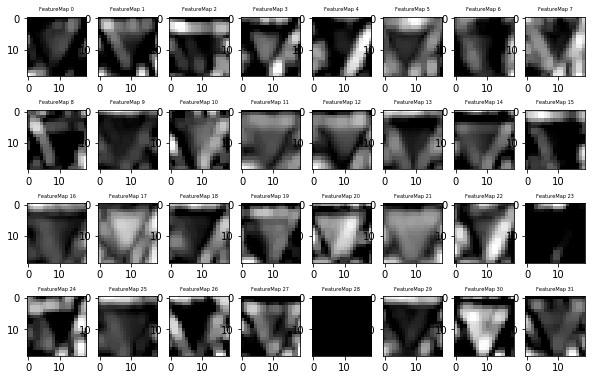

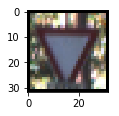

In [49]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

"""
Test the saved model against the test dataset
"""

# test_images, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
loaded_graph = tf.Graph()
# loaded_graph = tf.get_default_graph()

with tf.Session(graph=loaded_graph) as sess:
    # with tf.Session() as sess:
    # sess.run(tf.global_variables_initializer())

    # Load model
    loader = tf.train.import_meta_graph(save_model_path + ".meta")
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name("x:0")
    loaded_y = loaded_graph.get_tensor_by_name("y:0")
    loaded_keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
    loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    loaded_acc = loaded_graph.get_tensor_by_name("accuracy:0")

    # loaded_graph.

    conv_layer_1 = loaded_graph.get_tensor_by_name("hidden-layer-1:0")
    conv_layer_2 = loaded_graph.get_tensor_by_name("hidden-layer-2:0")
    conv_layer_3 = loaded_graph.get_tensor_by_name("hidden-layer-3:0")
    conv_layer_4 = loaded_graph.get_tensor_by_name("hidden-layer-4:0")
    conv_layer_5 = loaded_graph.get_tensor_by_name("hidden-layer-5:0")

    # "weights-layer-1"
    # "hidden-layer-1"

    stimuli = x_test_data[26]
    tf_image_input = np.reshape(stimuli, [-1, stimuli.shape[0], stimuli.shape[1], stimuli.shape[2]])
    
    print(" -------------------- Layer-2 ---------------------")
    Cnn.output_feature_map(tf_image_input, loaded_x, conv_layer_2, sess, activation_min=-1, activation_max=-1, plt_num=1)

    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(stimuli)

